# Recommender Systems with Python

Welcome to the code notebook for Recommender Systems with Python. In this lecture we will develop basic recommendation systems using Python and pandas. There is another notebook: *Advanced Recommender Systems with Python*. That notebook goes into more detail with the same data set.

In this notebook, we will focus on providing a basic recommendation system by suggesting items that are most similar to a particular item, in this case, movies. Keep in mind, this is not a true robust recommendation system, to describe it more accurately,it just tells you what movies/items are most similar to your movie choice.

There is no project for this topic, instead you have the option to work through the advanced lecture version of this notebook (totally optional!).

Let's get started!

## Import Libraries

In [1]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 3px  black solid !important;
  color: black !important;
}
# For having gridlines 

In [2]:
import numpy as np
import pandas as pd

## Get the Data

In [3]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp'] # List of column names
df = pd.read_csv('u.data', sep='\t', names=column_names) # Tab separated file and not comma separated, names = column_names

In [4]:
df.head() # Dataset being used is MovieLens
# Dataframe give user_id, item_id (movie) rating and timestamp at which rating was given.

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [5]:
# Getting movie titles
movie_titles = pd.read_csv("Movie_Id_Titles")

In [6]:
movie_titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [7]:
# We try to replace item_id with title, to prevent working with meaningless numbers.

df = pd.merge(df,movie_titles,on = "item_id")

In [8]:
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


# EDA

Let's explore the data a bit and get a look at some of the best rated movies.

## Visualization Imports

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

Let's create a ratings dataframe with average rating and number of ratings:

In [10]:
# df.groupby("title")['rating'].mean() # Gives us average or mean rating for every title.
df.groupby("title")['rating'].mean().sort_values(ascending = False).head() # Allows us to see us movies with best ratings.

title
Marlene Dietrich: Shadow and Light (1996)     5.0
Prefontaine (1997)                            5.0
Santa with Muscles (1996)                     5.0
Star Kid (1997)                               5.0
Someone Else's America (1995)                 5.0
Name: rating, dtype: float64

In [11]:
df.head(1)

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)


In [12]:
# Movies with most ratings
df.groupby('title')['rating'].count().sort_values(ascending = False).head()
# Gives us a series of movies as per number of ratings in descending order.

title
Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

In [13]:
# Creating a dataframe called ratings
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
# Gives us a series of movies as per ratings in descending order which we pass to the DataFrame using pd.DataFrame

In [14]:
ratings.head() # Gives us an index based off of movie title and its average rating.
# As we saw earlier, rating also is determined by how many people rated it. As a rating of 5 star which is given by only one
# person isn't much of a help to recommender system, we are looking for movies which have higher rating and more people watched
# it.

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


In [15]:
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())

In [16]:
ratings.head() # Gives Number of ratings and Average rating with index being movie title.

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


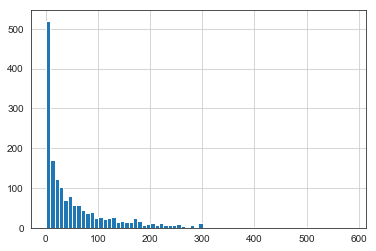

In [17]:
ratings['num of ratings'].hist(bins=70) # More bins as dataset is large.
# We see that most movies have 0 or 1 rating, which makes sense as people tend to watch blockbuster movies, and those will
# have more number of reviews.

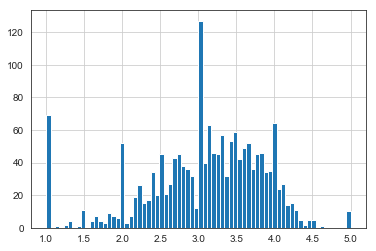

In [18]:
# Actual Ratings 
ratings['rating'].hist(bins=70)

# We notice that there are peaks at whole numbers like 1 to 5. This makes sense as people in general give whole number rating.
# Movies are distributed normally around 3 to 3 and a half stars.
# Also at 1 star there is an outlier where those movies are just bad ones.
# At 5 there is a small peak showing a lot of people liked the movie along with movies which were watched by a single person
# and he/she rated it 5 star.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


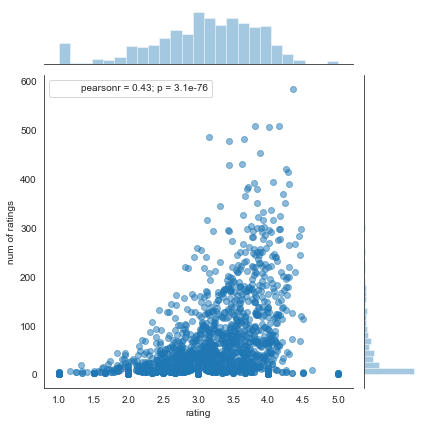

In [19]:
# Distribution or relationship between Actual Average Rating and Number of Ratings
import scipy.stats as stats

j = sns.jointplot(x='rating',y='num of ratings',data = ratings, alpha=0.5)
j.annotate(stats.pearsonr)
j.savefig('rating.jpg', format='jpg', dpi=1200) # To save the plot.
# We see that as number of ratings for a movie X increases then likelihood of X getting a higher rating also increases.
# Makes sense because if a movie is good, more people will watch it and give it a good rating.

Okay! Now that we have a general idea of what the data looks like, let's move on to creating a simple recommendation system:

## Recommending Similar Movies

Now let's create a matrix that has the user ids on one access and the movie title on another axis. Each cell will then consist of the rating the user gave to that movie. Note there will be a lot of NaN values, because most people have not seen most of the movies.

In [20]:
movie_mat = df.pivot_table(index='user_id',columns='title',values='rating')
movie_mat.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# We see that movie_mat has a lot of missing values. It makes sense as not everyone watches all the movies.
# we can go ahead and checkout some of the most rated movies as follows :
ratings.sort_values('num of ratings',ascending=False).head(10)

,rating,num of ratings
title,,
Star Wars (1977),4.359589,584
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485
"English Patient, The (1996)",3.656965,481
Scream (1996),3.441423,478
Toy Story (1995),3.878319,452
Air Force One (1997),3.631090,431


In [22]:
# Now we will choose 2 movies, Star Wars and Liar Liar, two being sci-fi and comedy movies respectively.
# Get the user ratings for those 2 movies.
starwars_user_ratings = movie_mat['Star Wars (1977)']
liar_user_ratings = movie_mat['Liar Liar (1997)']

In [23]:
starwars_user_ratings.head() # Gives rating of the movie according to user_id

user_id
0    5.0
1    5.0
2    5.0
3    NaN
4    5.0
Name: Star Wars (1977), dtype: float64

In [24]:
# We can use corrwith, to get correlation between 2 pandas series.
similar_to_starwars = movie_mat.corrwith(starwars_user_ratings)
# movie_mat.corrwith(starwars_user_ratings).sort_values(ascending=False)
similar_to_starwars.head()
# Compute pairwise correlation between rows or columns of DataFrame with rows or columns of Series or DataFrame.  
# DataFrames are first aligned along both axes before computing the correlations.

# This gives us a bunch of movies which are correlated to Star Wars.

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


title
'Til There Was You (1997)    0.872872
1-900 (1994)                -0.645497
101 Dalmatians (1996)        0.211132
12 Angry Men (1957)          0.184289
187 (1997)                   0.027398
dtype: float64

In [25]:
similar_to_liar = movie_mat.corrwith(liar_user_ratings)
similar_to_liar.head()

title
'Til There Was You (1997)    0.118913
1-900 (1994)                      NaN
101 Dalmatians (1996)        0.469765
12 Angry Men (1957)          0.066272
187 (1997)                   0.175145
dtype: float64

In [26]:
# Now we clean our similar_to series and convert it to Dataframe.
corr_starwars = pd.DataFrame(similar_to_starwars,columns=['Correlation'])
corr_starwars.dropna(inplace=True)

In [27]:
corr_starwars.head() # Creates a dataframe where index is title of the movie and Correlation rating next to it.
# This tells us how correlated this movie's ratings were compared to Star Wars user rating.

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398


- The correlation column tells us how correlated this movie's user ratings were to the star wars user ratings.
- On sorting the dataframe with correlation then we are expecting to get most similar movies, however we should know that in this process there are some results which do not make sense.

In [28]:
corr_starwars.sort_values('Correlation',ascending=False).head(10)
# This gives us movies which are having perfect 1.0 correlation with star wars, while in reality we haven't even heard the
# names of these movies. It is most likely due to the reason that maybe 1 user watched star wars and the movie with 1.0 and
# that reviewer happened to give both movies 5.0 rating.

,Correlation
title,
Commandments (1997),1.0
Cosi (1996),1.0
No Escape (1994),1.0
Stripes (1981),1.0
Man of the Year (1995),1.0
Hollow Reed (1996),1.0
"Beans of Egypt, Maine, The (1994)",1.0
"Good Man in Africa, A (1994)",1.0
"Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)",1.0


- We can fix this by filtering out movies having number of reviews below a threshold.
- As we see in plot below, there is a serious decline after 100 in number of ratings, so we filter out movies having less than 100 reviews.

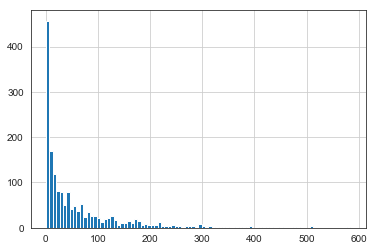

In [29]:
ratings['num of ratings'].hist(bins=90)

In [30]:
corr_starwars = corr_starwars.join(ratings['num of ratings']) # Joining dataframe together

In [31]:
corr_starwars.head()

,Correlation,num of ratings
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


In [32]:
# Filtering out movies not having 100 ratings
corr_starwars[corr_starwars['num of ratings']>100].sort_values('Correlation',ascending=False).head()

,Correlation,num of ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130


- Now this starts to make sense. 
- We see Star Wars, followed by Another Star Wars Movie and similar sci-fi movies which are related to it the most.

In [33]:
# Doing the same for liar liar movie
corr_liar = pd.DataFrame(similar_to_liar,columns=['Correlation'])

In [34]:
corr_liar.head()

,Correlation
title,
'Til There Was You (1997),0.118913
1-900 (1994),NaN
101 Dalmatians (1996),0.469765
12 Angry Men (1957),0.066272
187 (1997),0.175145


In [35]:
corr_liar.dropna(inplace=True) # As NaN aren't of much use in Recommender Systems.

In [36]:
corr_liar.head()

,Correlation
title,
'Til There Was You (1997),0.118913
101 Dalmatians (1996),0.469765
12 Angry Men (1957),0.066272
187 (1997),0.175145
2 Days in the Valley (1996),0.040739


In [37]:
corr_liar = corr_liar.join(ratings['num of ratings']) # Joining dataframe together

In [38]:
corr_liar.head()

,Correlation,num of ratings
title,,
'Til There Was You (1997),0.118913,9
101 Dalmatians (1996),0.469765,109
12 Angry Men (1957),0.066272,125
187 (1997),0.175145,41
2 Days in the Valley (1996),0.040739,93


In [39]:
corr_liar[corr_liar['num of ratings']>100].sort_values('Correlation',ascending=False).head()

,Correlation,num of ratings
title,,
Liar Liar (1997),1.000000,485
Batman Forever (1995),0.516968,114
"Mask, The (1994)",0.484650,129
Down Periscope (1996),0.472681,101
Con Air (1997),0.469828,137


- We see that as Liar Liar is a comedy, Mask is also a comedy by same Actor Jim Carrey, also as number of ratings decreases then correlation also goes down. Change the number of ratings threshold and see if you can get better recommendations, or maybe if you are able to filter out suggestions which do not make sense.